##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [2]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os

from keras.models import model_from_json
import ReadStandardTimeFill as RSTF
# pool.close()

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def TTV_Split(iteration,Memory,X,y,params,X_fill):
    if params['Save']['Model']==True:
        params['Save']['Weights'] = True
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val,params)

def RunReps(Model,params,Runs):
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv')
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    Yval = []
    y_val= []
    for i in range(params['K']):
        results = TTV_Split(i,Memory,X,y,params,X_fill)
        Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
        y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
        Runs['MSE'].iloc[i] = metrics.mean_squared_error(y_val,Yval)
        Runs['R2'].iloc[i] = metrics.r2_score(y_val,Yval)
        params=results[2]
        Runs['iteration'].iloc[i] = params['iteration']
        Runs['seed'].iloc[i] = params['seed']
    return(Runs)

In [105]:
FillVar = 'fco2'
Site = 'Illisarvik'
Vars = ['VWC','Sedge','Out_of_Basin']
Vars = ['wind_speed', 'PPFD_Avg', 'VPD', 'AirTC_Avg', 'VWC', 'Sedge', 'Shrub',
        'Out_of_Basin','Grass','Sparse']#	Water	Shrub	Sedge	Upland	Sparse
''
# Site = 'FishIsland'
# Vars = ['H','VWC','Active Layer','Water Table','']


N = 34

# Path = 
Runs,params = Dense.Params('Test',FillVar,MP=False)
cwd = os.getcwd()
params['Dpath'] = cwd+'/'+Site+'/'
Runs['iteration'] = 0
Runs['seed'] = 0
params['Dpath']=os.getcwd()+'/'+Site+'/'

params['N'] = N
params['Save']['Model'] = True
params['Model'] = '+'.join(Vars)
print(params)

Runs = Runs.iloc[0:params['K']].drop('Model',axis=1)
Runs['N'] = params['N']
Runs = RunReps(Vars,params,Runs)


{'proc': 1, 'K': 4, 'epochs': 100, 'Y': 'fco2', 'splits_per_mod': 2, 'Save': {'Weights': False, 'Model': True}, 'Dpath': 'C:\\Users\\wesle\\NetworkAnalysis/Illisarvik/', 'N': 34, 'Model': 'wind_speed+PPFD_Avg+VPD+AirTC_Avg+VWC+Sedge+Shrub+Out_of_Basin+Grass+Sparse'}
Saved model to disk


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [106]:
print(Runs.mean())
print()

N            34.000000
MSE           1.052500
R2            0.886275
iteration     0.500000
seed         25.000000
dtype: float64



In [107]:
def Load_Model(params):
    json_file = open(params['Dpath']+'/'+params['Y']+'/Weights/'+params['Model']+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return(loaded_model)
def Load_Weights(loaded_model,i,s):
    loaded_model.load_weights(params['Dpath']+'/'+params['Y']+'/Weights/'+params['Model']+'_'+str(i)+'_'+str(s)+'.h5')
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')
#     print("Loaded model from disk")
    return(loaded_model)
# print(Model)## Allows for calculation of partial derivatives & Mapping a over one dimension by fixing all other dimensions
def Fix(RST,Model,params,Vars,d,Fixed_Vals):
    di = [i for i,x in enumerate(Vars) if x == d]
    RST.Scale(params['Y'],Vars)
    y = RST.y*1.0
    X = RST.X*1.0
    Fixers = RST.XScaled.transform([Fixed_Vals])
    dx = X[:,di]
#     print(dx.shape)
    X[:,:]=Fixers
    X[:,di]=dx
    n=100
    Xnu = np.zeros((n,X.shape[1]))
    dx = np.linspace(X[:,di].min(),X[:,di].max(),n)[:,np.newaxis]
#     print(dx.shape)
    Xnu[:,:]=Fixers
    Xnu[:,di]=dx
#     print(X.shape)
    return(Xnu,RST)

In [108]:
print(RST.Master[Vars].mean())

wind_speed        3.867765
PPFD_Avg        332.631168
VPD             325.429551
AirTC_Avg         9.774409
VWC               0.548899
Sedge             0.105923
Shrub             0.367951
Out_of_Basin      0.124064
Grass             0.378160
Sparse            0.021764
dtype: float64


<IPython.core.display.Javascript object>


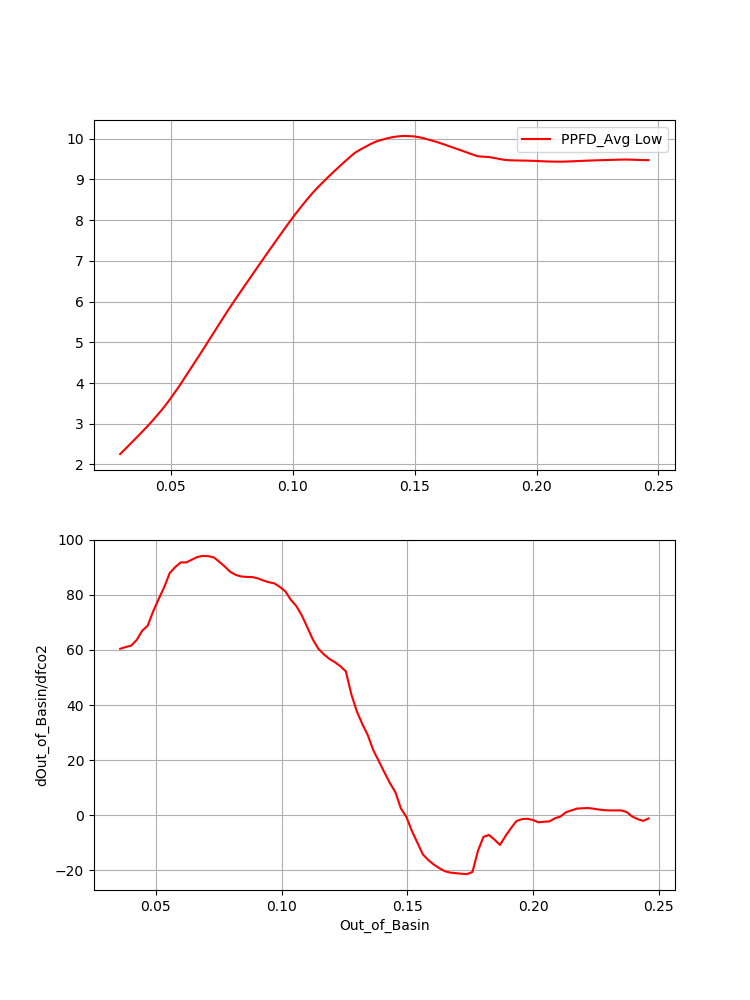

wind_speed        3.867765
PPFD_Avg          1.757000
VPD             325.429551
AirTC_Avg         9.774409
VWC               0.548899
Sedge             0.105923
Shrub             0.367951
Out_of_Basin      0.124064
Grass             0.378160
Sparse            0.021764
dtype: float64
(910, 1)
(100, 1)
(910, 10)
0    2.254014
Name: Pred, dtype: float32


In [115]:

from matplotlib.mlab import griddata
def Map(X,dx,params,Runs,ax,color,label,Offset=None):
    EmptyModel = Load_Model(params)
    results = []
    for i,s in zip(Runs['iteration'],Runs['seed']):
        Model = Load_Weights(EmptyModel,i,s) 
        results.append(Model.predict(X))
    results = np.asanyarray(results).mean(axis=0)
#     print(results.shape)
    results = RST.YScaled.inverse_transform(results.reshape(-1,1))
    X = RST.XScaled.inverse_transform(X)
#     plt.figure()
    data = pd.DataFrame(X,columns=Vars)
    data['Pred']=results*Offset
    print(data['Pred'].loc[data[dx]==data[dx].min()])
    ax[0].plot(data[dx],data['Pred'],color=color,label=label)
    data = data.sort_values(by=dx)
    data = data.groupby(dx).mean().reset_index()
    ax[0].grid()
#     plt.figure()
    data['d'+params['Y']+'/d'+dx]=((data['Pred'].diff()+data['Pred'].diff(3))/2)\
             /((data[dx].diff()+data[dx].diff(3))/2)
    ax[1].plot(data[dx],data['d'+params['Y']+'/d'+dx],(),color=color)
    ax[1].set_xlabel(dx)
    ax[1].set_ylabel('d'+dx+'/d'+params['Y'])
    ax[1].grid()
    ax[0].legend()

Model = Load_Model(params)
RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv')

if Site == 'FishIsland':
    dx = 'Wind Spd'
else:
    dx = 'Out_of_Basin'

# # Var = 'Active Layer'
Var = 'PPFD_Avg'
fig,ax = plt.subplots(2,1,figsize = (7.5,10))

# Fixed_Vals = RST.Master[Vars].mean()#quantile(.5)
# # Fixed_Vals['Sedge']=0.106560
# # Fixed_Vals['Shrub']=0.367200#RST.Master[Var].quantile(.85)
# Fixed_Vals[Var]=RST.Master[Var].max()
# # 'Sedge', 'Shrub'

# print(Fixed_Vals)
# X,RST=Fix(RST,Model,params,Vars,dx,Fixed_Vals.values)
# Map(X,dx,params,Runs,ax,color='blue',label=Var+' High',Offset=1e-6 * 44.0095 *3600*24)

Fixed_Vals = RST.Master[Vars].mean()#quantile(.25)
Fixed_Vals[Var]=RST.Master[Var].min()
# Fixed_Vals['Sedge']=0.106560
# Fixed_Vals['Shrub']=0.367200
print(Fixed_Vals)
X,RST=Fix(RST,Model,params,Vars,dx,Fixed_Vals.values)
Map(X,dx,params,Runs,ax,color='red',label=Var+' Low',Offset=1e-6 * 44.0095 *3600*24)
# print(X)


# Fixed_Vals = RST.Master[Vars].mean()
# print(Fixed_Vals)
# X,RST=Fix(RST,Model,params,Vars,dx,Fixed_Vals.values)
# Map(X,dx,params,Runs,ax,color='Green',label=Var+' Mean',Offset=1e-6 * 44.0095 *3600*24)
# print(X)

In [ ]:
#     score = loaded_model.evaluate(X, y, verbose=1)
# print(RST.Master[Vars].quantile(.85))

In [ ]:
# data = (data.groupby('VWC').mean())
# print(data)

In [ ]:
# plt.figure()